## Task 2a
Create cluster-irrelevant features in the data by e.g. perturbing features or replace with simulated noise features. Note, it is probably easier if you first filter out some cluster relevant features so you have an informative set to start from and keep these intact, but you are free to investigate the question of noisy features in other ways if you prefer.

Investigate how an increasing proportion of cluster-irrelevant features impact clustering and the selection of the number of clusters. Is this sensitive to how you choose to reduce dimensions or select features?

To make this interesting, explore at least 2-3 dimension reduction techniques. You can consider feature selection methods, projections, factorization methods or auto-encoders for example.

### Read data

In [14]:
import pyreadr
import numpy as np
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Loads the data
TCGAData = pyreadr.read_r('TCGAdata.RData') 

In [15]:
#Converts it to np.arrays and seperates labels form data
data = np.array(TCGAData['TCGA'])
labels = np.array(TCGAData['TCGAclassstr'])

unique_labels = np.unique(labels)
print(unique_labels)

values = unique_labels
print(values)
# integer encode

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
print(np.unique(labels))
print(data.shape)

['BC' 'GBM' 'KI' 'LU' 'OV' 'U']
['BC' 'GBM' 'KI' 'LU' 'OV' 'U']
[0 1 2 3 4 5]
(2887, 20530)


C:\Users\axelq\OneDrive\Skrivbord\MpCas\Statistical learning for big data\bigdatavenv1\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Feature selection

***PCA***

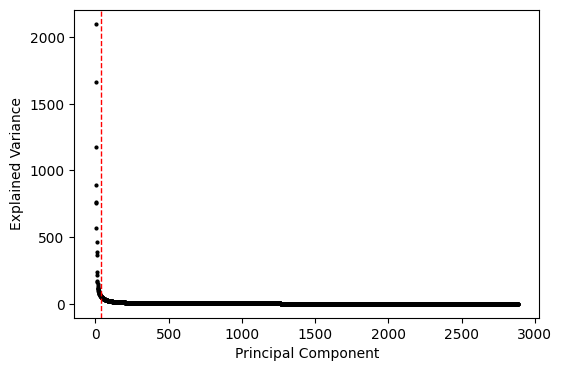

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data_pp = StandardScaler().fit_transform(data)
pca = PCA(svd_solver="auto").fit(data_pp)
# The PCA object offers convenient ways of accessing the
# principal directions and explained variance
pca.components_;
pca.explained_variance_;

# To get the principal components, the `transform` method of the
# PCA object can be used
principal_components_pca = pca.transform(data_pp)

fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.components_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(40, linestyle="dashed", color="red", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca(data, n_components):
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Fit PCA to the scaled data
    pca = PCA(n_components=n_components)
    pca.fit(scaled_data)
    
    # Transform the data using the fitted PCA model
    principal_components = pca.transform(scaled_data)
    
    # Return the principal components
    return principal_components

***Random projection***

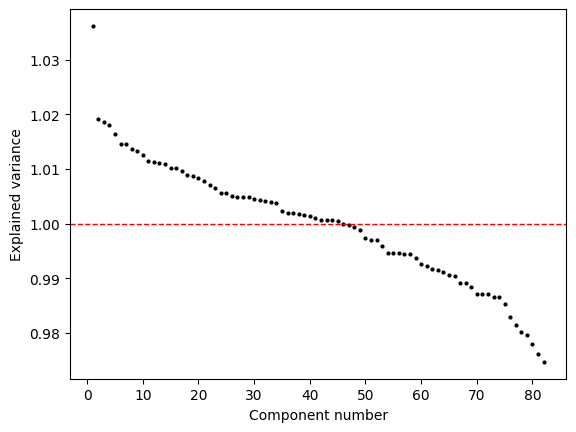

Number of components = 45


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(n_components=82).fit(data)

# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]

# Plot the scree plot
plt.plot(np.arange(1, len(explained_variances) + 1), explained_variances_sorted, 'ok',markersize=2)
plt.axhline(1, linestyle="dashed", color="red", linewidth=1)
plt.xlabel('Component number')
plt.ylabel('Explained variance')
plt.show()

n_components = np.sum(explained_variances_sorted > 1)
print(f'Number of components = {n_components}')

In [19]:
def random_projection(data, nr_components):
    scaled_data = StandardScaler().fit_transform(data)
    return GaussianRandomProjection(n_components=nr_components).fit_transform(scaled_data)
    

### Filter out cluster-relevant feature and perturb data after filtration

In [29]:
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm

#Select cluster relevant features using variance threshold
threshold = 3.798

sel = VarianceThreshold(threshold=threshold)
good_data = sel.fit_transform(data)
copy_good_data = np.copy(good_data)

mask = sel.get_support()
bad_data = data[:, ~mask]
copy_bad_data = np.copy(bad_data)

def perturb(percentage, bad_data):
    # Portion of perturbation
    portion = int(len(bad_data)*percentage)

    row_indices = np.random.choice(bad_data.shape[0], size=portion, replace=False)
    col_indices = np.random.choice(bad_data.shape[1], size=portion, replace=False)

    # Calculate means and standard deviations for the selected columns
    means = np.mean(bad_data[:, col_indices], axis=0)
    stds = np.std(bad_data[:, col_indices], axis=0)

    # Generate random numbers for the selected rows and columns
    r = np.random.normal(loc=means, scale=stds, size=(portion, portion))

    # Add the random numbers to the selected elements of the bad_data array
    bad_data[np.ix_(row_indices, col_indices)] += r
        
    return np.hstack((good_data, bad_data))  

***New perturbed data***

In [47]:
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm

#Select cluster relevant features using variance threshold
threshold = 3.798

sel = VarianceThreshold(threshold=threshold)
good_data = sel.fit_transform(data)
copy_good_data = np.copy(good_data)

mask = sel.get_support()
bad_data = data[:, ~mask]
copy_bad_data = np.copy(bad_data)



def pertub_include_not_all(percentage, bad_data):
    #Return data
    return_data = np.copy(good_data)
    
    
    nr_rows = bad_data.shape[0]
    # create a new column with zeros 
    zero_col = np.zeros((nr_rows, 1))
    # adding the new col of zeros to bad_data
    bad_data_copy = np.hstack((bad_data, zero_col))
    
    # Portion include bad data
    portion = int(len(bad_data)*percentage)

    row_indices = np.random.choice(bad_data.shape[0], size=portion, replace=False)
    col_indices = np.random.choice(bad_data.shape[1], size=portion, replace=False)
    
    # Calculate means and standard deviations for the selected columns
    means = np.mean(bad_data[:, col_indices], axis=0)
    stds = np.std(bad_data[:, col_indices], axis=0)

    # Generate random numbers for the selected rows and columns
    r = np.random.normal(loc=means, scale=stds, size=(portion, portion))

    # Add the random numbers to the selected elements of the bad_data array
    bad_data[np.ix_(row_indices, col_indices)] += r

    for i in col_indices:               
        return_data = np.hstack((return_data, bad_data_copy[:, i:i+1])) 

    return return_data

## Clustering method

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

def consensus_index(matrices):
    n = len(matrices)
    total_agreements = 0
    total_pairs = 0

    for i in range(n):
        for j in range(i+1, n):
            total_agreements += np.sum(matrices[i] == matrices[j])
            total_pairs += matrices[i].size

    return total_agreements / total_pairs


def kmeans_clustering_score(reduced_data, nr_clusters, score):
    kmeans = KMeans(init="k-means++", n_clusters=nr_clusters, n_init='auto').fit(reduced_data)
    pred = kmeans.labels_
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
        
    co_association_matrix = 1 - squareform(pdist(pred[:, np.newaxis], metric='hamming'))
    return score, pred, co_association_matrix

def spectral_clustering_score(reduced_data, nr_clusters, score):
    sc = SpectralClustering(n_clusters=nr_clusters, eigen_solver='lobpcg', n_init=10, gamma=1.0, affinity='nearest_neighbors',
                        n_neighbors=10, assign_labels='kmeans')
    pred = sc.fit_predict(reduced_data)
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
        
    co_association_matrix = 1 - squareform(pdist(pred[:, np.newaxis], metric='hamming'))
    return score, pred, co_association_matrix

def gmm_clustering_score(reduced_data, nr_clusters, score):
    gmm = GaussianMixture(n_components=nr_clusters, covariance_type='spherical')
    pred = gmm.fit_predict(reduced_data)
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
        
    co_association_matrix = 1 - squareform(pdist(pred[:, np.newaxis], metric='hamming'))
    return score, pred, co_association_matrix

def agglomerative_clustering_score(reduced_data, nr_clusters, score):
    agglomerative_clustering = AgglomerativeClustering(n_clusters=nr_clusters, metric='euclidean', linkage='ward')
    pred = agglomerative_clustering.fit_predict(reduced_data)
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
            
    co_association_matrix = 1 - squareform(pdist(pred[:, np.newaxis], metric='hamming'))
    return score, pred, co_association_matrix

In [31]:
from tqdm import trange
from tqdm import tqdm
import numpy as np

def evaluate(nr_PC, nr_clusters_list, data, method, iterations, metric, dim_tech):
    
    if dim_tech == 'pca':
        reduced_data = pca(data, nr_PC)
    elif dim_tech == 'rp':
        reduced_data = random_projection(data, nr_PC)
    
    cluster_dict = {}
    
    for c in nr_clusters_list:
        score_list = []
        co_association_matrices = []
        for i in tqdm(range(iterations), desc=f"Number of clusters {c}", position=0):
            if method == 'kmeans':
                score, pred_label, co_mat = kmeans_clustering_score(reduced_data, c, metric)
                
            elif method == 'spectral':
                score, pred_label, co_mat = spectral_clustering_score(reduced_data, c, metric)
            
            elif method == 'gmm':
                score, pred_label, co_mat = gmm_clustering_score(reduced_data, c, metric)
                
            elif method == 'agglo':
                score, pred_label, co_mat = agglomerative_clustering_score(reduced_data, c, metric)
            
            score_list.append(score)
        
        cluster_dict[c] = np.mean(score_list)
    return cluster_dict, pred_label


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
clfs_name = ['2', '3', '4', '5', '6', '7', '8', '9']
def barplot(score_values, score_names, Title):
    df = pd.DataFrame(score_values, index=score_names, columns=clfs_name)
    ax = df.plot.bar(rot=0, figsize=(10,6))
    
    
    # Add score names below the bars
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(clfs_name), title='Number of clusters')
    ax.set_ylabel('Value')
    ax.set_xticklabels(score_names)
    ax.set_title(Title)
    
    # Add exact values above the bars
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', fmt='%.2f', fontsize=4)
    
    plt.show()

In [32]:
def run_code(nr_clusters_list, nr_PC, iterations, dim_tech, methods, new_data):
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []


    for method in methods:
        print(method)
        silhouette_score_dict, pred_label = evaluate(nr_PC, nr_clusters_list, new_data, method, iterations, 'silh', dim_tech)
        print(f'Silhoutte scores for {method}:\n {silhouette_score_dict}')

        silhouette_scores.append(silhouette_score_dict.values())

        calinski_score_dict, pred_label = evaluate(nr_PC, nr_clusters_list, new_data, method, iterations, 'calinski', dim_tech)
        print(f'Calinski-Harabasz scores for {method}:\n {calinski_score_dict}')

        calinski_scores.append(calinski_score_dict.values())

        davies_bouldin_dict, pred_label = evaluate(nr_PC, nr_clusters_list, new_data, method, iterations, 'davies', dim_tech)
        print(f'Davies-Bouldin scores for {method}:\n {davies_bouldin_dict}')

        davies_bouldin_scores.append(davies_bouldin_dict.values())


    return silhouette_scores, calinski_scores, davies_bouldin_scores

In [33]:
import matplotlib.pyplot as plt

def min_max_normalize(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val)


def plot_func(silh_score, cal_score, davies_score, perturbed_percentage):
    # Assume calinski_scores, silhouette_scores, davies_bouldin_scores are your score arrays
    normalized_calinski = min_max_normalize(np.array(list(cal_score[0])))
    normalized_silhouette = min_max_normalize(np.array(list(silh_score[0])))
    normalized_davies_bouldin = min_max_normalize(np.array(list(davies_score[0])))
    best_score = 0
    
    for i, (s1, s2, s3) in enumerate(zip(normalized_silhouette, normalized_calinski, normalized_davies_bouldin)):
        score = s1+s2-s3
        if score > best_score:
            idx = i+2
            best_score = score
        

    plt.plot(nr_clusters_list, normalized_silhouette, '-o', label='Silhouette')
    plt.plot(nr_clusters_list, normalized_calinski, '-o', label='Calinski-Harabasz')
    plt.plot(nr_clusters_list, normalized_davies_bouldin, '-o', label='Davies-Bouldin')
    plt.xlabel('Nr Clusters')
    plt.ylabel('Value')
    plt.axvline(x=idx, color='k', linestyle='--', label='Optimal cluster count')
    plt.title(f'GMM, perturbed level: {perturbed_percentage*100}%')
    plt.legend()
    plt.show()

### Get perturbed data

In [45]:
percentages = [0.3, 0.5, 0.7]
perturbed_data_list = []
for p in percentages:
    new_data = perturb(p, bad_data)
    perturbed_data_list.append(new_data)

  9%|███████▎                                                                         | 78/866 [00:02<00:29, 26.67it/s]


KeyboardInterrupt: 

In [50]:
percentages = [0, 0.3, 0.5, 0.7]
perturbed_data_list = []
for p in percentages:
    new_data = pertub_include_not_all(p, bad_data)
    perturbed_data_list.append(new_data)

0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 2020/2020 [02:41<00:00, 12.54it/s]


## PCA

gmm


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


Silhoutte scores for gmm:
 {2: 0.2539550698028689, 3: 0.24626541367931506, 4: 0.25397390230456435, 5: 0.2923383633565819, 6: 0.3042045718066511, 7: 0.2886625987223419, 8: 0.2852827936564053, 9: 0.2781807783679873}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]


Calinski-Harabasz scores for gmm:
 {2: 611.8864803589067, 3: 618.0962322245134, 4: 685.0075443831583, 5: 757.4818605349195, 6: 760.5537565371135, 7: 701.2954186464937, 8: 674.2856573853487, 9: 649.8175027062808}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]

Davies-Bouldin scores for gmm:
 {2: 1.3208656877524194, 3: 1.4820686462882986, 4: 1.4822735817284496, 5: 1.4492928057789767, 6: 1.4371168656285753, 7: 1.5939976367055084, 8: 1.5639727376620038, 9: 1.5502801874891963}


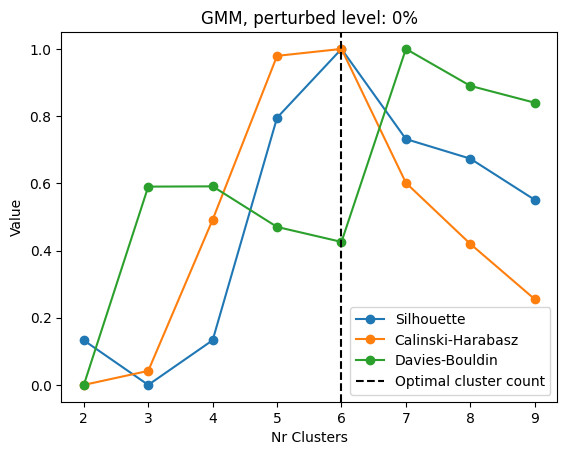

gmm


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.21it/s]


Silhoutte scores for gmm:
 {2: 0.23860704772480787, 3: 0.21005043142826932, 4: 0.23832699143956526, 5: 0.27105969105532013, 6: 0.278701800428674, 7: 0.27442039136702834, 8: 0.2736786596049862, 9: 0.26855853990865036}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]


Calinski-Harabasz scores for gmm:
 {2: 575.7441827118664, 3: 587.4299195690993, 4: 618.4837079825325, 5: 644.7699791701409, 6: 631.8212442798557, 7: 608.8725419476694, 8: 569.3163846956356, 9: 577.2356851731655}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]

Davies-Bouldin scores for gmm:
 {2: 1.5349824401787604, 3: 1.603067125587587, 4: 1.607674304201191, 5: 1.5200507487973929, 6: 1.6126357872550876, 7: 1.6715463633635357, 8: 1.6303412857419417, 9: 1.6354621503739266}


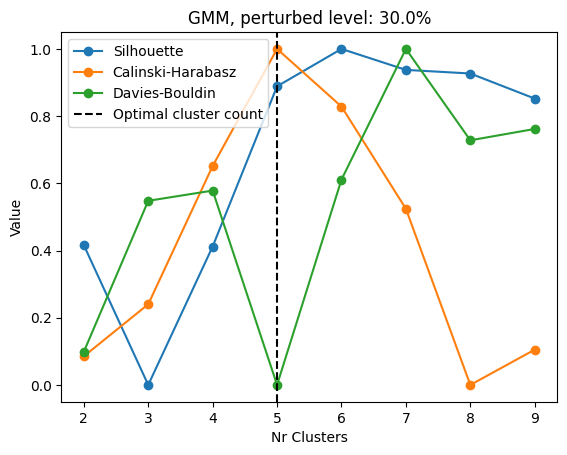

gmm


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


Silhoutte scores for gmm:
 {2: 0.22525804758351387, 3: 0.21322928350739473, 4: 0.23109849850114397, 5: 0.2569804530313988, 6: 0.26827653669156193, 7: 0.2676908698721158, 8: 0.26501360764604287, 9: 0.2507429490774576}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


Calinski-Harabasz scores for gmm:
 {2: 568.8406429463269, 3: 553.9256607479488, 4: 586.3175736131299, 5: 595.6485121779853, 6: 600.1862850740994, 7: 563.677010235448, 8: 552.0404053290237, 9: 516.5533476243546}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.51it/s]

Davies-Bouldin scores for gmm:
 {2: 1.547938320826334, 3: 1.7323208305099913, 4: 1.6351037988565764, 5: 1.5855960883211946, 6: 1.6646708592977126, 7: 1.6968560976078462, 8: 1.6662920219880957, 9: 1.680594308638212}


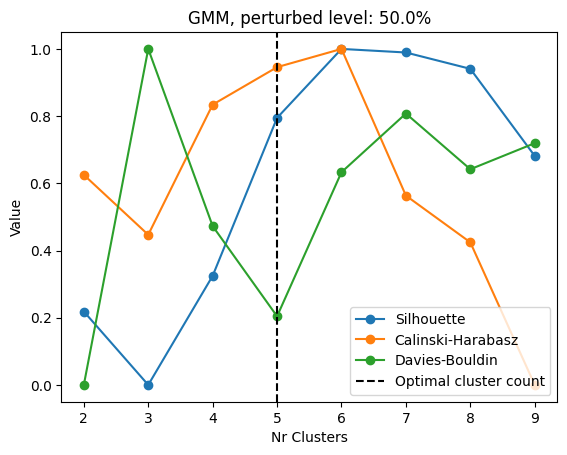

gmm


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.94it/s]


Silhoutte scores for gmm:
 {2: 0.22619060168568886, 3: 0.20761864862413407, 4: 0.22327761712105088, 5: 0.26246218369127966, 6: 0.263678470041289, 7: 0.268364080467352, 8: 0.2558236132840822, 9: 0.25095324778276057}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.32it/s]


Calinski-Harabasz scores for gmm:
 {2: 596.7497554020433, 3: 542.535677761156, 4: 562.7389709548028, 5: 600.8940913339773, 6: 577.0516138485581, 7: 544.944507517105, 8: 529.1557874380348, 9: 512.0483623862909}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]

Davies-Bouldin scores for gmm:
 {2: 1.617150312744531, 3: 1.7386335710939103, 4: 1.6758075532500778, 5: 1.5671830426768623, 6: 1.6673112642471737, 7: 1.7536232598469241, 8: 1.6879962850355668, 9: 1.6649931922951446}


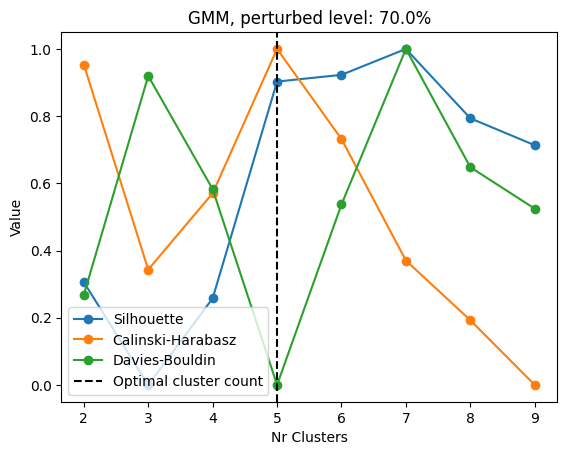

In [51]:
# Function arguments
nr_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9]
nr_PC = 40
iterations = 50
dim_tech = 'pca'
methods = ['gmm']

for i, perturbed_data in enumerate(perturbed_data_list):
    silhouette_scores, calinski_scores, davies_bouldin_scores = run_code(nr_clusters_list, nr_PC, 
                                                                         iterations, dim_tech, methods, perturbed_data)

    plot_func(silhouette_scores, calinski_scores, davies_bouldin_scores, percentages[i])

## Random Projection

gmm


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.94it/s]


Silhoutte scores for gmm:
 {2: 0.18163322626441597, 3: 0.18507314969396269, 4: 0.20949949421699351, 5: 0.2045009370834857, 6: 0.18428602672806974, 7: 0.18220816545782778, 8: 0.17156033711386623, 9: 0.15843716944895492}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.81it/s]


Calinski-Harabasz scores for gmm:
 {2: 612.4981223660025, 3: 506.19034363678225, 4: 461.62525047260914, 5: 428.249775724509, 6: 379.10554316356865, 7: 350.5983176425785, 8: 324.2578983821281, 9: 302.43792134113914}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.23it/s]

Davies-Bouldin scores for gmm:
 {2: 1.9563661174812195, 3: 1.8929371189565631, 4: 2.08956489400955, 5: 2.077697991413859, 6: 2.068704607704601, 7: 2.022846639865655, 8: 1.9915780829256762, 9: 2.002403592089524}


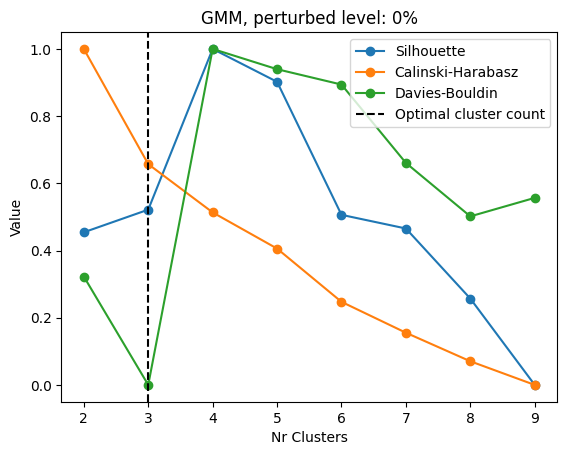

gmm


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


Silhoutte scores for gmm:
 {2: 0.12957080711490754, 3: 0.15287513481301565, 4: 0.18405303952977753, 5: 0.20264151089769747, 6: 0.19589230565449242, 7: 0.17846110935900733, 8: 0.16703564987787067, 9: 0.14266461020867532}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.16it/s]


Calinski-Harabasz scores for gmm:
 {2: 445.0670310054414, 3: 381.0745437174596, 4: 375.460606104499, 5: 340.5728538017792, 6: 317.04415323175346, 7: 284.6873820212048, 8: 258.27579682797887, 9: 239.32369013337538}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.03it/s]

Davies-Bouldin scores for gmm:
 {2: 1.5552639770363683, 3: 2.2029154499132027, 4: 2.415834056171949, 5: 2.623358971831115, 6: 2.51789172253081, 7: 2.545059664028195, 8: 2.5389825163625668, 9: 2.585086525891051}


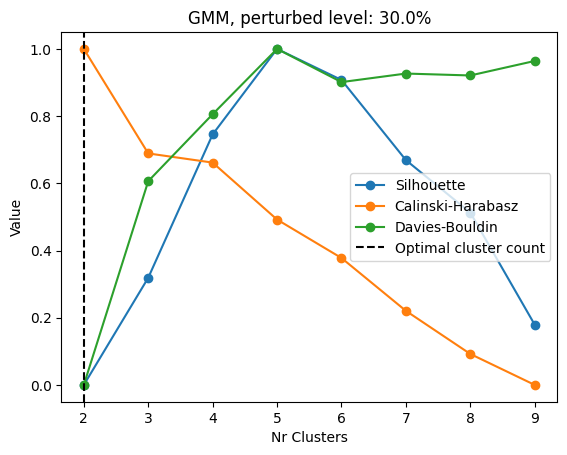

gmm


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.97it/s]


Silhoutte scores for gmm:
 {2: 0.12406161412772905, 3: 0.12655102433531565, 4: 0.1353375770819924, 5: 0.15352215969877253, 6: 0.14446692530010827, 7: 0.14305912758494616, 8: 0.12018708643271632, 9: 0.10429657667940412}


Number of clusters 9: 100%|████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.31it/s]


Calinski-Harabasz scores for gmm:
 {2: 327.6771756769816, 3: 293.79524064246533, 4: 285.9686945624648, 5: 269.3273228154532, 6: 254.8441815439592, 7: 231.44808508796532, 8: 211.5531031278342, 9: 196.72306870719459}


Number of clusters 8:  88%|████████████████████████████████████████████████████▊       | 44/50 [00:09<00:01,  4.72it/s]

In [ ]:
# Function arguments
nr_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9]
nr_PC = 40
iterations = 50
dim_tech = 'rp'
methods = ['gmm']

for i, perturbed_data in enumerate(perturbed_data_list):
    silhouette_scores, calinski_scores, davies_bouldin_scores = run_code(nr_clusters_list, nr_PC, 
                                                                         iterations, dim_tech, methods, perturbed_data)

    plot_func(silhouette_scores, calinski_scores, davies_bouldin_scores, percentages[i])

In [ ]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure